# 0.0 IMPORTS

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import xgboost as xgb
import warnings
import pickle
import random
import warnings

from boruta                import BorutaPy
from tabulate              import tabulate
from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.core.display  import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import RandomForestClassifier
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings( 'ignore' )

### 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 20]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 1000
    pd.set_option( 'display.expand_frame_repr', False ) 
    sns.set()
    
    
jupyter_settings()   

Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading Data

In [3]:
df_train_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_train_raw, df_store_raw, on=['Store'], how='inner')

In [19]:
df_raw.sample().T

,412001
Store,452
DayOfWeek,4
Date,2014-06-19
Sales,5940
Customers,550
Open,1
Promo,1
StateHoliday,0
SchoolHoliday,0
StoreType,a


# 1.0 DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [6]:
cols_old = df1.columns.values

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
85484,94,6,2014-05-03,5522,553,1,0,0,0,d,c,14620.0,NaN,NaN,0,NaN,NaN,NaN


### 1.2 Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


### 1.3 Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [11]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].fillna(df1['competition_distance'].mean())

#competition_open_since_month    
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['competition_open_since_month'].mean())

#competition_open_since_year     
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['competition_open_since_year'].mean())

#promo2                               
df1['promo2'] = df1['promo2'].fillna(df1['promo2'].mean())

#promo2_since_week               
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['promo2_since_week'].mean())

#promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['promo2_since_year'].mean())

#promo_interval                
df1['promo_interval'] = df1['promo_interval'].fillna(df1['promo_interval'].mode().iloc[0])

### 1.6 Change Types

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,75860.0,75840.0,5430.085652,2330.0,7705.293872,2.932345,13.041687
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999


### 1.7.2 Categorical Attributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

date                            942
state_holiday                     4
store_type                        4
assortment                        3
competition_open_since_month     12
competition_open_since_year      23
promo2_since_week                24
promo2_since_year                 7
promo_interval                    3
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

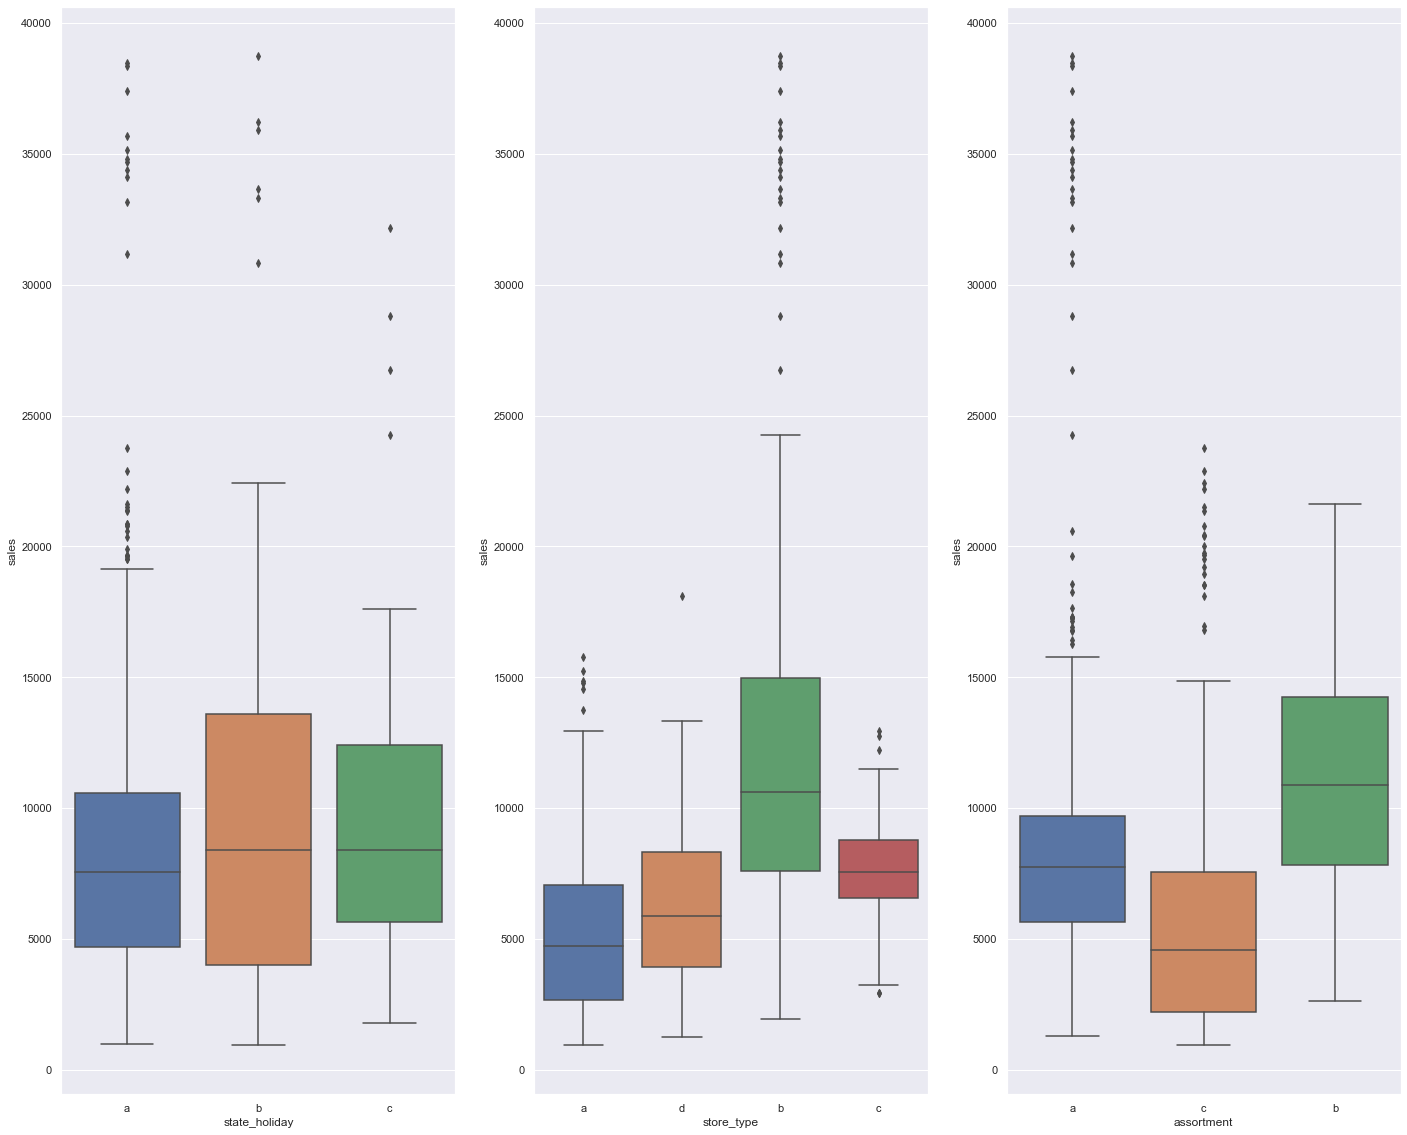

In [17]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

##  2.1 Mind Map Hipothesis

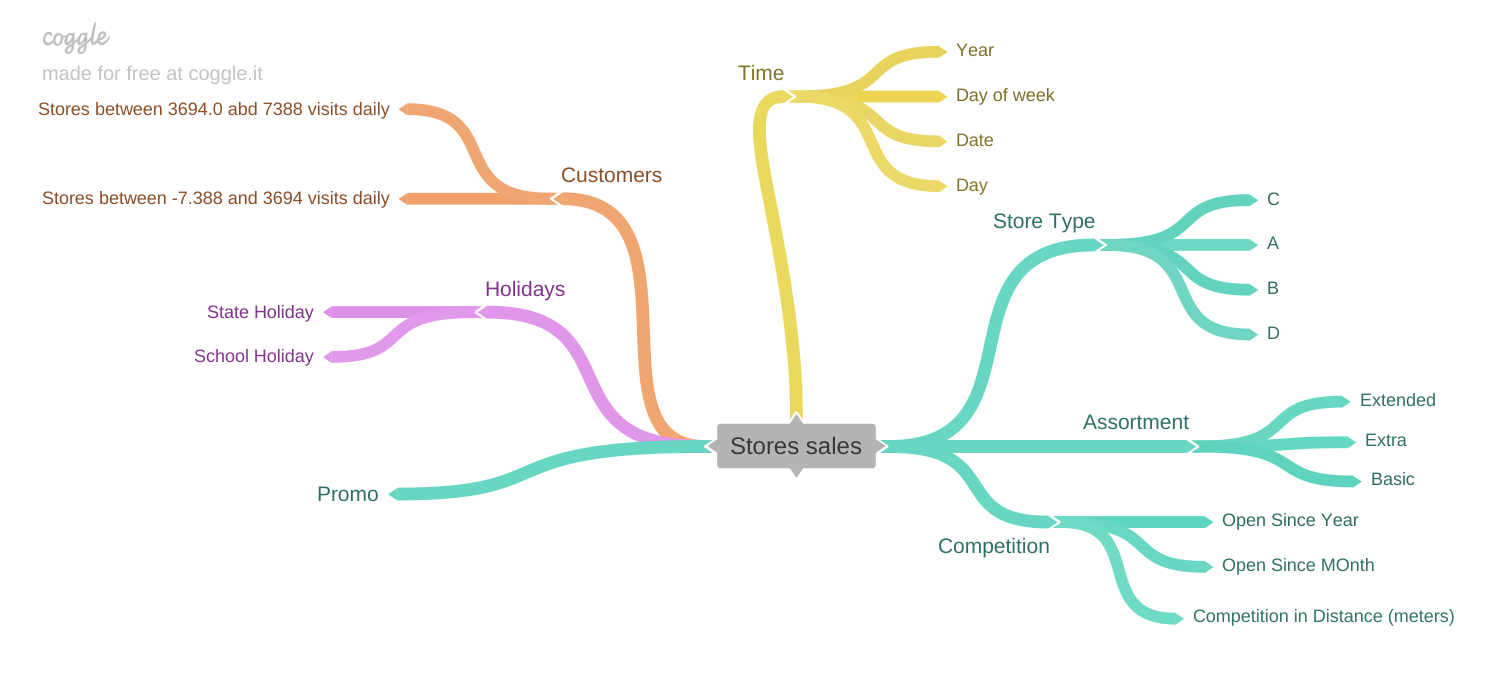

In [34]:
Image('../MindMapHipothesis.png')

## 2.3 Hipothesis

**H1** Lojas deveriam vender mais no inicio do ano. 

**H2** Lojas deveriam vender mais na segunda-feira 

**H3** Lojas de modelo tipo C deveriam mais.

**H4** Lojas de sortimento extra deveriam vender mais.

**H5** Lojas com competidores próximos deveriam vender menos.

**H6** Lojas com competidores maduros deveriam vender menos.

**H7** Lojas com promoções deveriam vender mais.

**H8** Lojas deveriam vender mais em dias de feriados estaduais.

**H9** Lojas com maior número de clientes diários deveriam vender mais.

## 2.4 Feature Engineering

In [53]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + \
                     df2['promo2_since_week']. astype(str)
    
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 
                                                             'easter_holiday' if x == 'b' else
                                                             'christmas'      if x == 'c' else 'regular_day' )

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if ['promo_interval'] == 0 else
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

# 3.0 FILTRAGEM DAS VARIÁVEIS

In [54]:
df3 = df2.copy()

## 3.1 Filtragem das Linha

In [55]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selação das Colunas

In [56]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

KeyError: "['month_map'] not found in axis"

# 4.0 ANALISE EXPLORATÓRIA DOS DADOS

In [60]:
df4 = df3.copy()

## 4.1 Analise Univariada

## 4.1.2 Response  Variable

<AxesSubplot:xlabel='sales'>

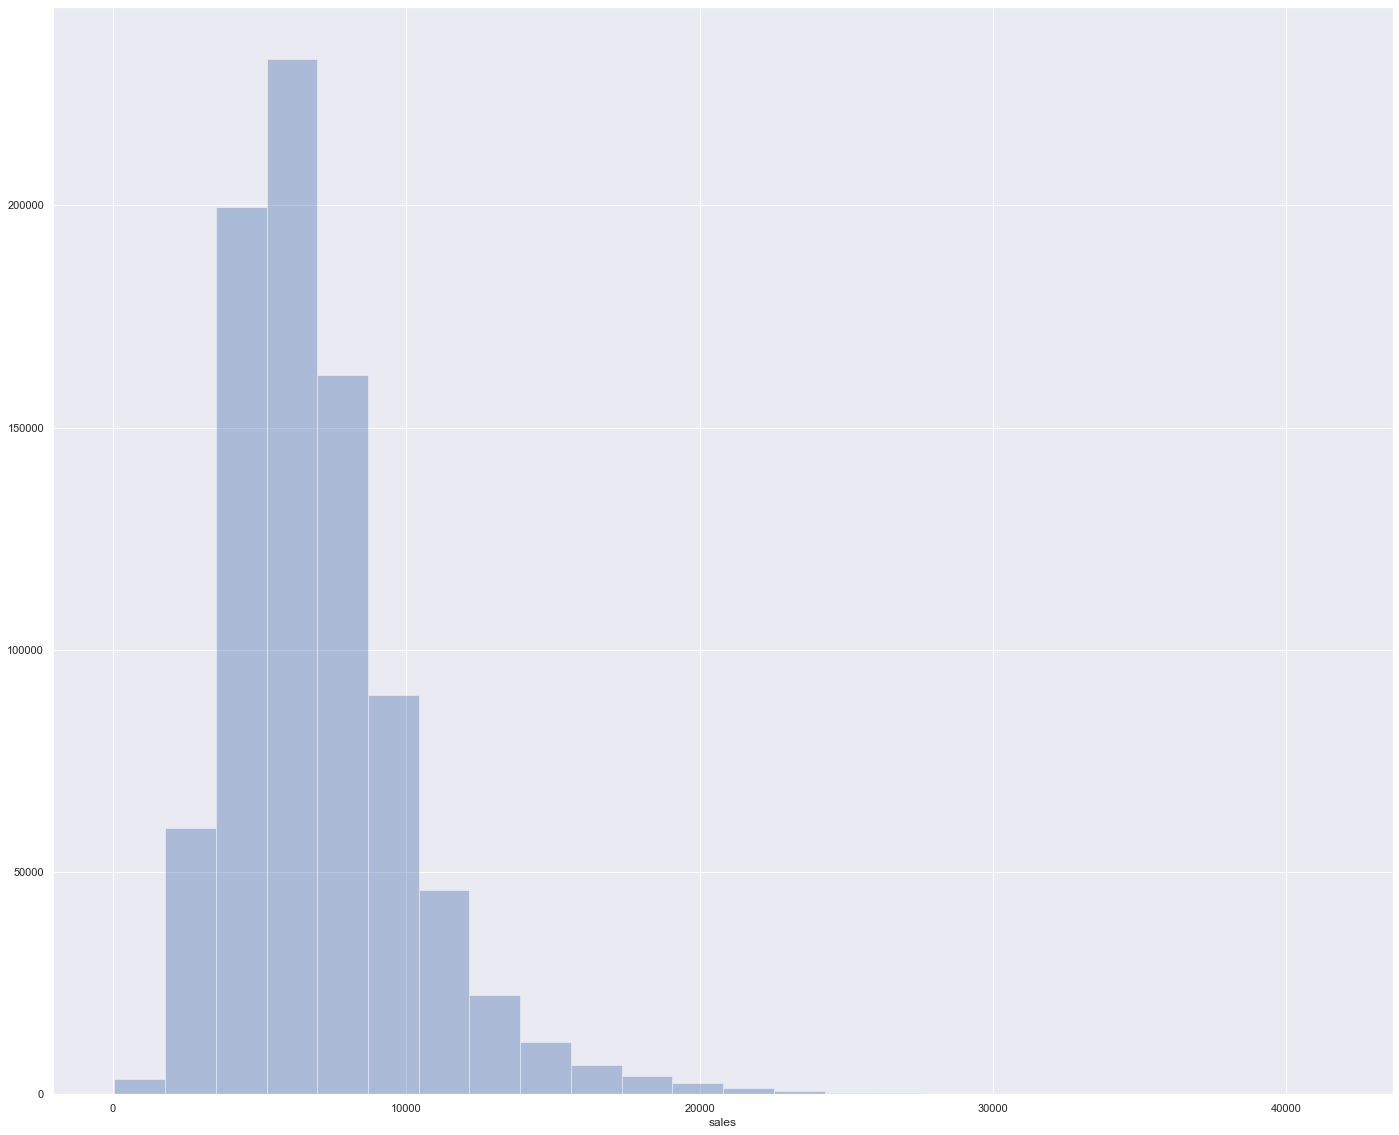

In [61]:
sns.distplot(df4['sales'] , bins=24, kde= False)

## 4.1.3 Numerical Variables

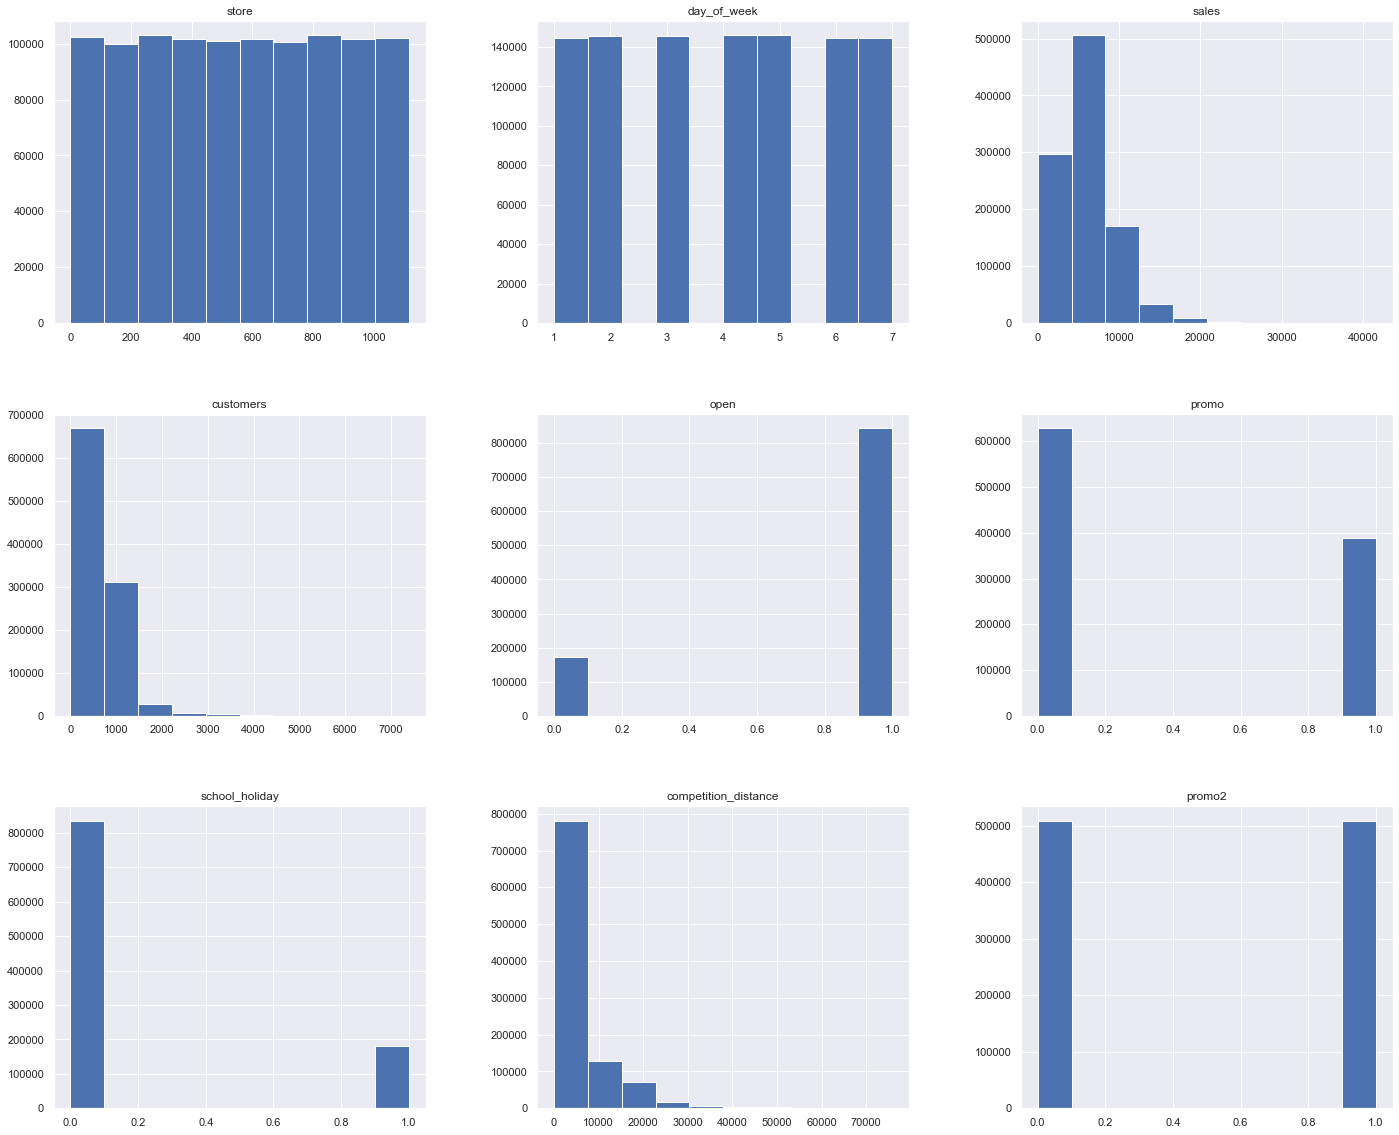

In [62]:
num_attributes.hist();

## 4.1.4 Categorical Variables

## 4.2 Analise Bivariada

## 4.3 Analise Multivariada

## 4.3.1 Numerical Attributes

<AxesSubplot:>

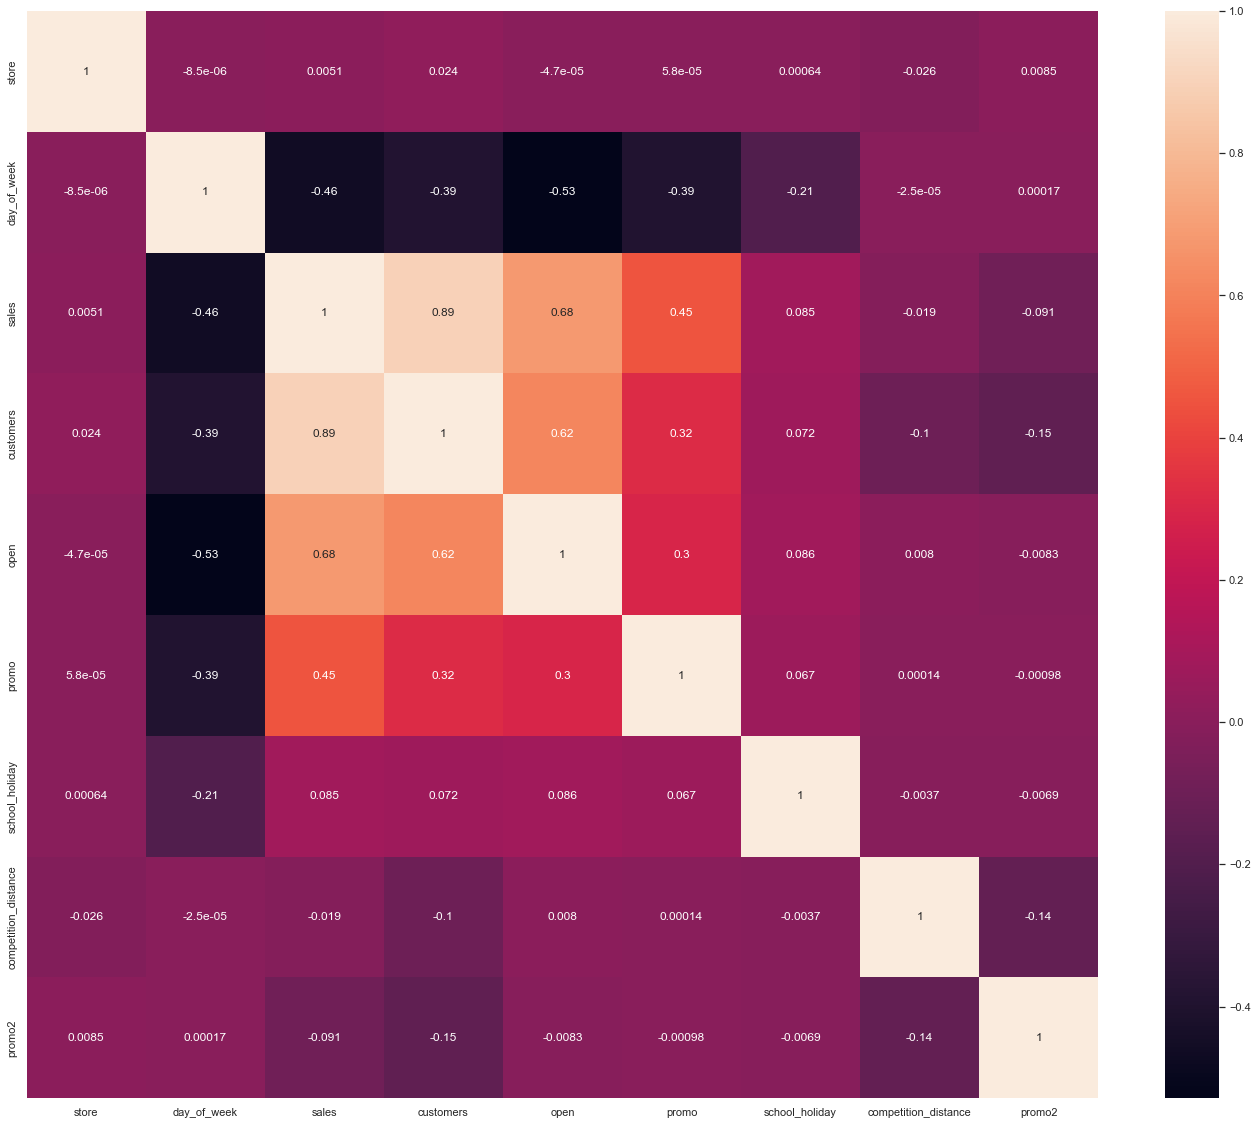

In [63]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

## 4.3.2 Categorical Attributes

## 4.4 Resumo das Hipoteses

# 5.0 PREPARAÇÃO DOS DADOS

In [64]:
df5 = df4.copy()

## 5.2 Scaling

In [66]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
#pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
#pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
#pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
#pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3 Transformação


### 5.3.1 Encoding

In [67]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Responsable Variable Transformation

In [68]:
df5['sales'] = np.log1p( df5['sales'] )

# 6.0 FEATURE SELECTION

In [74]:
df6 = df5.copy()

## 6.1 Split dataframe into train and test

In [75]:
cols_drop = ['week_of_year', 'promo_since', 'competition_since']
df6 = df6.drop( cols_drop, axis=1 )

In [76]:
X = df6.drop(['sales'], axis=1)
y = df6['sales']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.3, random_state=42)

## 6.2 Boruta as Feature Selector

In [48]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )


## 6.3. Manual Feature Selection

In [81]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

## 7.1 Average Model

In [84]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1445.842824,0.46566,1976.491001


In [85]:
from prophet import Prophet

ModuleNotFoundError: No module named 'prophet'

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

# 10.0 DEPLOY MODEL TO PRODUCTION